#### RL Course by David Silver

## Reinforcement Learning Assignment: Easy21

The goal of this assignment is to apply reinforcement learning methods to a simple card game that we call *Easy21*. This exercise is similar to the Blackjack example in Sutton and Barto 5.3 – please note, however, that the rules of the card game are different and non-standard.

 - The game is played with an infinite deck of cards (i.e. cards are sample with replacement)
 - Each draw from the deck results in a value between 1 and 10 (uniforml distributed) with a colour of red (probability 1/3) or black (probability 2/3).
 - There are no aces or picture (face) cards in this game
 - At the start of the game both the player and the dealer draw one *black* card (fully observed)
 - Each turn the player may either *stick* or *hit*
 - If the player *hits* then she draws another card from the deck
 - If the player *sticks* she receives no further cards
 - The values of the player’s cards are added (black cards) or subtracted (red cards)
 - If the player’s sum exceeds 21, or becomes less than 1, then she “goes bust” and loses the game (reward -1)
 - If the player sticks then the dealer starts taking turns. The dealer always sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome – win (reward +1), lose (reward -1), or draw (reward 0) – is the player with the largest sum.

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 1 Implementation of Easy21

In [71]:
class Player:
    '''Player of Easy21 game.
    
    Attributes:
        current_points: A integer of player's maximum current points
    '''
    def __init__(self):
        self.current_points = 0
        
    def get_card(self, card):
        '''Get a card from the card deck.'''
        self.current_points += card

class Dealer(Player):
    '''Dealer of Easy21 game, another kind of player.
    
    Attributes:
        first_card: A integer, the number of dealer's first card, 'black' is guaranteed.
    '''
    def __init__(self):
        Player.__init__(self)
        self._first_step = True
        self.first_card = 0
    
    def get_card(self, card):
        '''Get a card, and mark the first card as first_card.'''
        if self._first_step:
            self._first_step = False
            self.first_card = card
        Player.get_card(self, card)


class Easy21:
    '''Easy21 game.
    
    Attributes:
        winner: A string of winner's name.
    '''
    def __init__(self):
        self._player = Player()
        self._dealer = Dealer()
        self._player.get_card(np.random.randint(1, 11)) # first card, 'black' guanranteed
        self._dealer.get_card(np.random.randint(1, 11))
        self.winner = ''
    
    @staticmethod
    def generate_card():
        '''generate a card range from 1 to 10 with 2/3 probability 
                    and range from -1 to -10 with 1/3 probability  
        '''
        return np.random.randint(1, 11) * -int(((np.random.randint(0, 3) % 2) - 1 / 2) * 2)
    
    def stick(self):
        while self._dealer.current_points < 17 and self._dealer.current_points > 0:
            self._dealer.get_card(self.generate_card())
        if self._dealer.current_points > 21 or self._dealer.current_points < 1:
            self.winner = 'player'
        elif self._dealer.current_points < self._player.current_points:
            self.winner = 'player'
        elif self._dealer.current_points == self._player.current_points:
            self.winner = 'none'
        else:
            self.winner = 'dealer'
            
    def hit(self):
        self._player.get_card(self.generate_card())
        if self._player.current_points > 21 or self._player.current_points < 1:
            self.winner = 'dealer'
            
    def get_game_state(self):
        '''
        Return current game state: 
        player's point and dealer's first card 
        '''
        return (self._player.current_points, self._dealer.first_card)

class MDP_to_Easy21():
    '''MDP wrapper for Easy21 game.
    
    '''
    winner_to_reward = {
        'player' :  1,
        'dealer' : -1,
        'none'   :  0,
        ''       :  0
    }
    state_space_shape = (22,11)
    def __init__(self):
        self.is_terminate = False
        self._game = Easy21()
        
    
    def get_state(self):
        '''Get the current state of MDP.
        
        Returns:
            A tuple, ()
            tuple[0]: A integer, player's current points, 
            tuple[1]: A integer, dealer's face up card
        '''
        return self._game.get_game_state()
    
    def act(self, action):
        '''Take actions in a MDP.
        
        Args:
            action
        Returns:
            reward
            next state
        '''
        if action == 'hit':
            self._game.hit()
            if self._game.winner != '':
                self.is_terminate = True
        elif action == 'stick':
            self._game.stick()
            self.is_terminate = True
        return self.winner_to_reward[self._game.winner], self.get_state()

In [68]:
def naive_policy(state):
    return 'hit' if state[0] < 20 else 'stick'

In [72]:
def MC_Learning(MDP, episodes, policy, gamma = 1):
    episode = 0
    V = np.zeros(MDP.state_space_shape)
    N = np.zeros(MDP.state_space_shape)
    while episode < episodes:
        S = []
        R = []
        G = 0
        mdp = MDP()
        s = mdp.get_state()
        while not mdp.is_terminate:
            S.append(s)
            a = policy(s)
            r, s = mdp.act(a)
            R.append(r)
        while len(S) > 0:
            s = S.pop()
            r = R.pop()
            G = gamma * G + r
            N[s] += 1
            V[s] += (G - V[s])/ N[s]
        episode += 1
    return V

In [80]:
V = MC_Learning(MDP_to_Easy21, 1000000, naive_policy)

(22, 11)

In [101]:
def plot_result(V, title):
    V = V[1:22, 1:11]
    y = np.arange(21)           # 生成 x 坐标，表示玩家此刻的点数
    x = np.arange(10)             # 生成 y 坐标，表示庄家的明牌
    x, y = np.meshgrid(x, y)        # 生成 meshgrid
    # 画图
    fig = plt.figure(figsize=(6, 9))
    ax = Axes3D(fig)
    ax.plot_surface(x, y, V, rstride=1, cstride=1, cmap='hot')
    ax.set_xlabel("Dealer's face-up card")
    ax.set_ylabel("Player's Points")
    fig.suptitle(title)

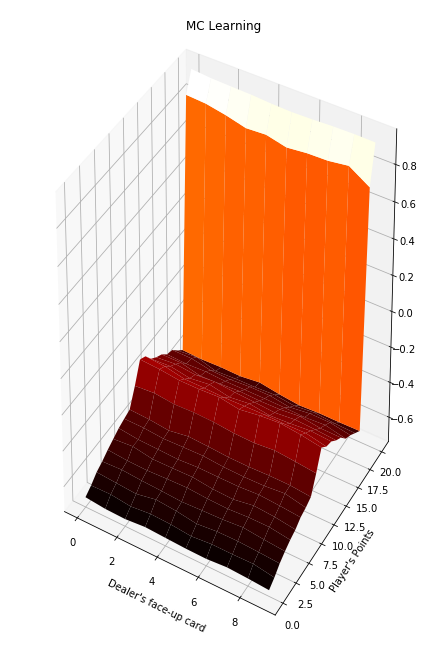

In [102]:
plot_result(V, 'MC Learning')